# Spot the spots

Alex Pletzer NIWA hacky hour August 2 2019

This notebook shows how machine learning can be applied to feature detection. You're faced with the tedious task of counting "spots" present in a large number of data samples. The spots may represent pictures of fishes, tropical cyclones, skin moles, tumours or black holes - you choose.

*You want to hand over the task to a machine so you can spend more time relaxing with friends, family or at the beach.*

## Input parameters

In [1]:
# input values - feel free to change
numTrain = 1000 # number of training samples
numTest = 100 # number of testing samples
numCells = 40 # the data have size numCells x numCells
maxNumSpots = 5 # the maximum number of spots 0...maxNumSpots

## Some convenience functions

Function to generate 2D data with spots at random locations

In [2]:
import numpy as np
np.random.seed(123)  # so that results are reproducible
#TODO: set tensorflow random seed too

xs = np.linspace(0., 1., numCells)
ys = np.linspace(0., 1., numCells)
xxs, yys = np.meshgrid(xs, ys)

def generateRandomData(numCells, maxNumSpots):
  """
  Generate random data with spots (Gaussian field over zero background)
  @param numCells number of cells in x and y
  @param maxNumSpots max number of spots
  @return array with elements between 0 and 1
  """
  numSpots = int(maxNumSpots * np.random.random() + 0.5)
  data = np.zeros((numCells, numCells), np.float64)
  for i in range(numSpots):
    # random radius
    rad = 0.1 + 0.0*np.random.random()  # currently fixed radius of 0.1
    # random location
    x0, y0 = 0.1 + 0.8*np.random.random(), 0.1 + 0.8*np.random.random()
    data += np.exp( -((xxs - x0)**2 + (yys - y0)**2)/rad**2 )
  # normalize, filter nans
  maxVal = data.max()
  if maxVal != 0:
    data /= maxVal
  data = np.nan_to_num(data)
  
  return data, numSpots

Function to plot the data

In [3]:
%matplotlib inline
import matplotlib.pylab as plt

numCols = 5
def plotData(iBeg, iEnd, dataInput, dataOutput, dataReferenceOutput=[]):
  """
  Plot the data
  @param iBeg start index in the dataset (list of 2D data)
  @param iEnd one past the last index in the dataset
  @param dataInput dataset
  @param dataOutput number of spots for each data array
  @param dataReferenceOutput correct number of spots for each data array
  """
  numPlots = iEnd - iBeg
  numRows = numPlots // numCols
  if numPlots % numCols > 0:
    numRows += 1
  for i in range(iBeg, iEnd):
    plt.subplot(numRows, numCols, i - iBeg + 1)
    plt.imshow(dataInput[i, ...], cmap='YlOrBr')
    plt.axis('off')
    txt = '{:.1f}'.format(dataOutput[i])
    if len(dataReferenceOutput) > 0:
      txt += ' ({})'.format(dataReferenceOutput[i])
    plt.title(txt, fontsize=8)
  plt.show()

## Creating the training samples

In [4]:
# allocate memory
trainInput = np.zeros((numTrain, numCells, numCells), np.float32)
trainOutput = np.zeros((numTrain,), np.int8)
# fill in the data for each training sample
for i in range(numTrain):
  trainInput[i, ...], trainOutput[i] = generateRandomData(numCells, maxNumSpots)

Plotting a subset of the training dataset

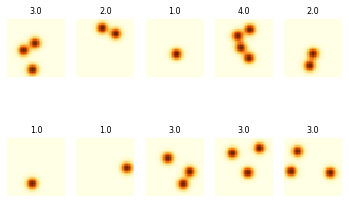

In [5]:
plotData(0, min(10, numTrain), trainInput, trainOutput)

## Creating the test samples

In [6]:
# allocate memory
testInput = np.zeros((numTest, numCells, numCells), np.float32)
testOutput = np.zeros((numTest,), np.int8)
# fill in the data for each testing sample
for i in range(numTest):
  testInput[i, ...], testOutput[i] = generateRandomData(numCells, maxNumSpots)

Plotting a subset of the training dataset

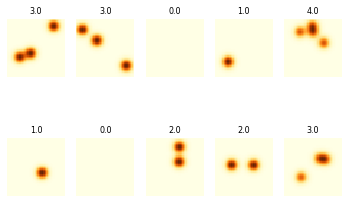

In [7]:
plotData(0, min(10, numTest), testInput, testOutput)

## Creating a neural network and training it

In [8]:
from tensorflow import keras

# build the neural network
model = keras.Sequential()

# first layer - looking at fine details
model.add( keras.layers.Conv2D(8, kernel_size=(3,3), strides=(1,1),
                             padding='same', data_format='channels_last',
                             activation='relu') )  # relu is activation - never get below zero, linear scale with output
model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)) )  # which filter most successful in identifying certain feature
# play with num filters (8), kernel_size, kernel_size

# second layer - looking at coarser details...
model.add( keras.layers.Conv2D(8, kernel_size=(3,3), strides=(1,1),
                             padding='same', data_format='channels_last',
                             activation='relu') )
model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)) ) # pool size

# add a dense layer with linear regression
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dense(1) )  # only one output (approx num spots)
# could have mapped into an array (output), max num spots elements, output is probability of each number spots

model.compile(optimizer='adam', loss='mean_squared_error',
            metrics=['accuracy']) # look into this may be better as something else

# now train 
numEpochs = 20
history = model.fit(trainInput.reshape(-1, numCells, numCells, 1),  # input is 4d tensor with shape (batch, rows, cols, channels) when using "channels_last"
                    trainOutput, epochs=numEpochs)

Train on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 1s 1ms/sample - loss: 5.6639 - accuracy: 0.1580
Epoch 2/20
1000/1000 [==============================] - 1s 572us/sample - loss: 0.8397 - accuracy: 0.2040
Epoch 3/20
1000/1000 [==============================] - 1s 588us/sample - loss: 0.5780 - accuracy: 0.2040
Epoch 4/20
1000/1000 [==============================] - 1s 587us/sample - loss: 0.4930 - accuracy: 0.2360
Epoch 5/20
1000/1000 [==============================] - 1s 597us/sample - loss: 0.4394 - accuracy: 0.3070
Epoch 6/20
1000/1000 [==============================] - 1s 608us/sample - loss: 0.4307 - accuracy: 0.3070
Epoch 7/20
1000/1000 [==============================] - 1s 581us/sample - loss: 0.4254 - accuracy: 0.3070
Epoch 8/20
1000/1000 [==============================] - 1s 573us/sample - loss: 0.4186 - accuracy: 0.3070
Epoch 9/20
1000/1000 [==============================] - 1s 606us/sample - loss: 0.4119 - accuracy: 0.3070
Epoch 10/20
1000/1000 [===

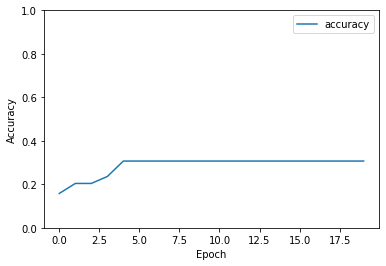

In [9]:
# plot the model accuracy
plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='best')
plt.show()

In [10]:
# give a summary of the model 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  801       
Total params: 1,465
Trainable params: 1,465
Non-trainable params: 0
______________________________________________________

## Predicting the the number of spots in each test sample

In [11]:
predictions = model.predict(testInput.reshape(-1, numCells, numCells, 1))[:, 0]
# compute the errors: difference between predictions and testOuput
errors = np.round(predictions) - testOutput
numErrors = (errors != 0).sum()
print(errors)
print(f'num errors = {numErrors} ({100*numErrors/numTest} %)')
# could use f'{numErrors}'

[ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.
  0.  0. -1.  0. -1.  0.  0. -2.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0. -2. -1.  0.  0. -1. -1.  0. -1.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.
  0. -1.  0.  0.  0.  1. -1.  0. -1.  0.]
num errors = 25 (25.0 %)



Plotting datasets for which the predictions were wrong

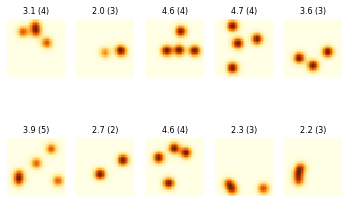

In [12]:
inds = np.nonzero(errors != 0)[0]
failuresInput = testInput[inds, :]
failuresOutput = predictions[inds]
correctOutput = testOutput[inds]
numFailures = len(failuresOutput)
plotData(0, min(10, numFailures), failuresInput, failuresOutput, correctOutput)